## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
# Ex. 1.

import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda, float32

A = np.array([2, 5, 10, 3, 8], dtype='float32')

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_log(x):
    return math.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_exp(x):
    return math.exp(x)

print("Vectorized Log:", vec_log(A))
print("Vectorized Exp:", vec_exp(A))

Vectorized Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [2]:
# Ex. 2.

@vectorize([float32(float32)], target='parallel', fastmath=True)
def gaussian_pdf(x):
    mu  = 1
    sig = 1
    return math.exp(-(((x-mu)/sig)**2)/2)

size = 100000
x = np.linspace(-3, 3, size, dtype='float32')
gaussian_pdf(x)

array([0.00033546, 0.00033554, 0.00033562, ..., 0.13536775, 0.13535155,
       0.13533528], dtype=float32)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

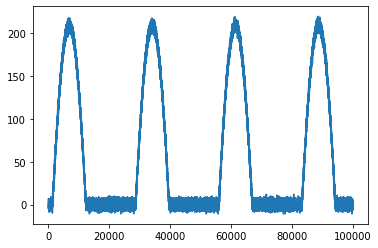

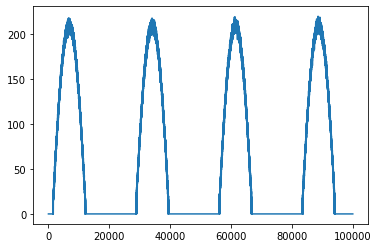

In [3]:
# Ex. 3.

%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@jit
def zero_suppression(x, threshold):
    for i in range(len(x)):
        if x[i] < threshold : x[i] = 0
    return x

plt.plot(data)
plt.show()

plt.plot(zero_suppression(data, 15))
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
# Ex. 4.

import math

x = np.random.rand(3,3).astype('float32')
y = np.random.rand(3,3).astype('float32')
res = np.zeros((3,3), dtype='float32')

alpha = 1.
c = 0.

@cuda.jit
def sigmoid_kernel(x, y, result, alpha, c):    
    row, col = cuda.grid(2)
    
    if row < result.shape[0] and col < result.shape[1]:
        tmp = 0.
        for k in range(x.shape[0]):
            tmp += x[k, row] * y[k, col]
        
        result[row, col] = math.tanh(alpha * tmp + c)
    
sigmoid_kernel[(1,1), (3,3)](x, y, res, alpha, c)

print(res)

[[0.8020206  0.7605645  0.92026937]
 [0.6535577  0.77741355 0.7549027 ]
 [0.46947205 0.6145157  0.45018527]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [5]:
# Ex. 5.

from numba import cuda

@cuda.jit
def double_kernel(k):
    x, y, z = cuda.grid(3)
    if x < k.shape[0] and y < k.shape[1] and z < k.shape[2]:
        k[x][y][z] = math.cos(k[x][y][z])

data = np.random.normal(size=(256,256,256))

threadsperblock = (16, 16)
blockspergrid = (int(data.shape[0] / threadsperblock[0]), int(data.shape[1] / threadsperblock[1]))

double_kernel[blockspergrid, threadsperblock](data)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [6]:
# Ex. 6.

from __future__ import division
from numba import cuda

@cuda.jit
def matmul(A, B, C):
    x, y = cuda.grid(2)
    if (x < C.shape[0] and y < C.shape[1]):
        count = 0.
        for k in range(A.shape[1]):
            count += A[x,k]*B[k,y]
        C[x,y] = count

A = np.random.randint(100, size=(24,12))
B = np.random.randint(100, size=(12,22))
C = np.zeros((24,22))

threadsperblock = (24, 22)
blockspergrid = (1, 1)

matmul[blockspergrid, threadsperblock](A, B, C)